# Homework 04: Midway Check-in Final Project


In [1]:
# June Wagner
# Homework 04

import math
import numpy as np
import pandas as pd
import time
from datetime import datetime
from matplotlib import pyplot as plt

## 2. Data Collection
### 2.1 Data Description

In [2]:
# Write a short description of the dataset (200+ words). Think on: where data was collected from, how, whose data it is, what
# are the main features of the dataset, how old it is, how often it is updated... etc.

# Dataset: "Game Recommendations on Steam" - by Anton Kozyriev, last updated 13 December 2023 (accessed 29 April 2024).
# Update frequency: semi-monthly basis; last updated 5 months ago.
# https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam
# All data was collected from Steam, an online games store / games library application run by Valve Corporation.
# https://store.steampowered.com/
#
# There are four files in total: games.csv, games_metadata.json, recommendations.csv, and users.csv. According to the dataset's
# webpage, these files represent over 41 million user recommendations of games on Steam; according to my exploration, there are
# some 50,000 games represented--some of which are only Downloadable Content (DLC) or musical Original Soundtrack (OST).
# 
# games.csv contains a list of games on Steam as they appear in a snapshot--even their discounts (a temporary variable).
#    Each entry has an app_id that is unique, a title (does not contain commas), a date it was released on Steam,
#    which operating systems it is available on (Windows, Mac, Linux), a rating (e.g. positive, mixed, overwhelmingly negative),
#    the ratio of positive ratings (e.g. 90), the number of user-submitted reviews, the price (before and after any discount),
#    and whether it is available on the Steam Deck (almost all are).
# 
# games_metadata.json is a metadata .json file that adds colorful information to each game entry, like developer-submitted
#    descriptions of their game(s) and selected genre tags for the games. Many games lack a description and/or a genre tag.
# 
# recommendations.csv: a many-to-many relation between games and users, with positive and negative (TRUE or FALSE) reviews.
#    Each review has a recorded app_id to identify the game being reviewed, and a review_id to identify the individual review.
#    Although "helpful" and "funny" are included metrics, they represent other-user engagement with a given review.
#    The reveiwer's user_id is included, and their number of hours played on the given game is also given (as low as 0, rarely).
#    A date is also included, which could be helpful for quantifying a more-recent review as worth more than a less-recent one.
#
# users.csv: a list of users, their number of products (games), and their number of reviews. Very few have 0 games or 0 reviews.
#
# According to the description on Kaggle, the dataset is built from information already accessible to the public, and all 
# users are assigned an anonymized user ID.

# ***All of this information is further expanded in 3.1.1

### 2.2 Dataset Download

In [3]:
# 2.2.1: Download the dataset to the folder data.

# Don't forget to do this, June :)
# ** Add data to the git ignore file, so it is not pushed to the repository (because it's not our data to upload/distribute)...

## 3. Data Preprocessing
### 3.1 Data Cleaning

In [4]:
# 3.1.1 Perform some initial data exploration to understand the dataset better.

# games.csv:
#    games.csv contains a list of games on Steam as they appear in a snapshot--even their discounts (a temporary variable)
#    app_id - a critical information point that identifies each entry to a unique number
#    title - much less important; some of these titles contain bizarre characters, especially around trademark symbols... badly translated into ascii?
#    date_release - release date in (m)m/(d)d/yyyy format. We might filter out entries beyond 2020 since that's where the RepresentMe database stops.
#    win - available on a Windows platform. 
#    mac - available on a Mac platform.
#    linux - available on a Linux platform. (Least common)
#       If a game is triple-negative (not win, mac, or linux) it seems to be an Soundtrack and/or Artbook.
#          * I should remove these entries and ignore their app_id in other .csv data files.
#
#    rating - 9 Categories, by this general rubric:
#           - Overwhelmingly Positive: 95%+ positive reviews; 500+ reviews
#           - Very Positive          : 85%+ positive reviews; 50+ reviews
#           - Positive               : 80%+ positive reviews; 10+ reviews
#           - Mostly Positive        : 70%+ positive reviews; 10+ reviews
#           - Mixed                  : 40%+ positive reviews; 10+ reviews
#           - Mostly Negative        : 20%+ positive reviews; 10+ reviews
#           - Negative               : 00%+ positive reviews; 10+ reviews
#           - Very Negative          : 00%+ positive reviews; 50+ reviews
#           - Overwhelmingly Negative: 00%+ positive reviews; 500+ reviews
#       If a game is Mostly Negative or worse, I should probably strike it from the model? We are trying to recommend good game experiences.
#    positive_ratio - the ratio of positive reviews, accurate to 2 digits (e.g. 94% or 11%).
#       I think that this is relatively redundant to the "rating", especially because "rating" includes a "confidence" (i.e. 'very')
#    user_reviews - the number of reviews a game has had (min: 10 max: 7494460). 
#       There are no games with fewer than 10 reviews here, and this is useful because a game needs 10+ reviews to qualify for "rating"
#       
#       * I think that 'rating' makes for a decent enough metric that it is okay to mostly ignore the positive_ratio and user_reviews,
#          especially since it is a useful product of those two and represents both positivity and confidence of a positive experience.
#
#    price_final - price after a discount is applied to the price_original.
#    price_original - the original price of the game, before any potential discount is applied.
#    discount - the percentage (min: 0%; max: 90%) discount on the game.
#        This is a mostly trivial section of the data, but it is useful to report price and/or discount as part of the game insofar as
#        an end user would like to know how much a game costs before following through with a purchase. I would consider this to be
#        a more decorative sort of data, not very important to what we're trying to accomplish here.
#    steam_deck - TRUE or FALSE: compatible with the Steam Deck gaming platform. There are exactly two games that are FALSE.

# games_metadata.json: a metadata .json file that adds information to each game entry.
#     app_id: a unique number assigned to each game, perfectly 1-for-1 to the game's entry in games.csv app_id.
#     description: flavor text that may or may not exist (i.e. some entries are null), as a description for the game.
#     tags: game genres as an array (e.g. Action, Adventure, Simulation, RTS, 2D, Rougelike); some entries are empty / null.
#        
#        * This could be useful information except that so many games don't have tags and/or a description! 
#        I think it is worth delivering this info to the end-user at least; it could be worth exploring a user's 
#        preference for genres if the many-to-many users.csv file doesn't deliver similarly important information.

# recommendations.csv: a many-to-many relation between games and users, with positive and negative (TRUE or FALSE) reviews.
#     app_id: a unique number assigned to each game, exactly the same as in games.csv and games_metadata.json ...
#     helpful: the number of other-user reactions to this review that indicate it is "helpful" (range: 0, 2 to 16163),
#        more than half of these entries are "0", but that doesn't necessarily mean these reviews are unhelpful.
#        Potentially just that this user review hasn't had many eyes on it.
#     funny: the number of other-user reactions to this review that indicate it is "funny" (range: 0, 2 to 8818),
#        more than 3/4 of these entries are "0". This might not be an especially useful metric except that it means that
#        other users have read and engaged with this review.
#     date: the date a review was published. This could be helpful, since more recent reviews are more relevant to the current
#        release of the game than older reviews.
#     is_recommended: TRUE or FALSE. "FALSE" (i.e. negative) is fewer than 1/10 of the reviews. A negative review is much less common
#        than a positive one. Are negative reviews useful for steering our decisions? Maybe even more than positive reviews?
#        After all, a negative review means a lot more than simply no review at all. A user must really go out of their way for it!
#        But they are much less common than positive reviews; positive reviews will likely form the majority basis for what we 
#        want to accomplish here.
#     hours: the number of hours a user has in a game, (range: 0 to 999.9; clearly truncating at 999.9 as so many users will have
#        more than 1000 hours); this can be seen as a "confidence" of the review. A review with 0 hours may be worth less than a
#        review at 999.9+ hours.
#     user_id: a number assigned to each unique user; this number can repeat--this means that that user has made multiple reviews.
#     review_id: a number assigned to each unique review.

# users.csv: a list of users, their number of products (games), and their number of reviews.
#     user_id: a number assigned to each unique user. Just as in recommendations.csv.
#     products: the number of games the user has (range: 0, 2 to 21112). Very few are 0.
#        I think that users that have "0" products actually 'used' to own one or more games, but now do not own any (refund?)
#        (Maybe confiscation for violation of Steam's Terms of Service?)
#     reviews: the number of reviews this user has produced (range: 0 to 1762); very few are 0.
#        I wonder if the users with "0" reviews actually created a review that was removed? Maybe for moderation reasons (profanity)?
#     

In [5]:
# 3.1.2 Address missing data, if any, by appropriately identifying and quantifying missing values in the dataset.

# By visual inspection (messing around in Excel) the data shows no null values except in the .json, where there are many 
# games with no description and/or tags (genre). The dataset does not have users with 1 product, games with <10 reviews, etc.,
# so it would appear that the dataset has already had some cleaning done to it and I won't be able to tell if some values
# were changed. I wonder if the lack of "1" as a datapoint in some columns is because it could be read as "TRUE" in some 
# programs. I assume that some--but not all--outliers are already dealt with.


# WIP: 

# See 3.1.5 for checking for further missing values.

In [6]:
# 3.1.3 Apply suitable techniques to handle missing values (e.g. imputation, exclusion) based on a logical approach.
# 3.1.4 Justify the chosen method in 50+ words.

# This dataset is already quite clean, as shown in 3.1.5
# While the games_metadata.json does have quite a few missing values, it is already not going to be relied on. If it could
# have at least one tag for (most) games, I might see about using imputation to classify the remainder as "untagged" and see
# if tags could be used to help recommend games, but in the current circumstances this doesn't make much sense.

# I suppose I am excluding information from the games_metadata.json altogether for its incompleteness. If it is used, it will
# be in order to deliver flavorful information to the end user about the generated recommendations.

In [7]:
# 3.1.5.a Checking for missing values with code. (games.csv)
games_df = pd.read_csv("games.csv")


games_df.info() # get a simple summary
games_df.isna().sum() # if all numbers are 0, there are no null values.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB


app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64

In [8]:
# 3.1.5.b Checking for missing values with code. (users.csv)
users_df = pd.read_csv("users.csv")

users_df.info() # get a simple summary
users_df.isna().sum() # if all numbers are 0, there are no null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB


user_id     0
products    0
reviews     0
dtype: int64

In [9]:
# 3.1.5.c Checking for missing values with code. (recommendations.csv)   *** WARNING: THIS TAKES TIME! 2.2+ GB data into memory!
recom_df = pd.read_csv("recommendations.csv")

recom_df.info() # get a simple summary
recom_df.isna().sum() # if all numbers are 0, there are no null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB


app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64

In [10]:
# 3.1.5.d Checking for missing values with code. (games_metadata.json)
gmeta_df = pd.read_json("games_metadata.json", lines = True)  # *** Throws ValueError for "trailing data" if not lines = True

gmeta_df.info() # get a simple summary
gmeta_df.isna().sum() # if all numbers are 0, there are no null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_id       50872 non-null  int64 
 1   description  50872 non-null  object
 2   tags         50872 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


app_id         0
description    0
tags           0
dtype: int64

### 3.2 Outlier Detection

In [11]:
# 3.2.a Check for outliers: games_df

# *** I want to use games_df as an example of finding outliers and excluding them.
#     This is already a very clean dataset, so removing datapoints shouldn't be done just because they skew distribution.
#     This is just how I would do it if I was going to :)

# Then, I will apply math (interquartile range * some threshold, like 1.5) to find specific outliers.
# Finally, I will deal with these outliers logically.
pd.options.display.float_format = '{:.0f}'.format # This option suppresses Pandas's scientific notation, allows 0 decimal.

# I will start with games_df
games_df.describe()

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,50872,50872,50872,50872,50872,50872
mean,1055224,77,1824,9,9,6
std,610325,18,40074,12,12,19
min,10,0,10,0,0,0
25%,528738,67,19,1,1,0
50%,986085,81,49,5,5,0
75%,1524895,91,206,11,12,0
max,2599300,100,7494460,300,300,90


In [12]:
# 3.2.a games_df outliers check continued

# We should ignore app_id. This might as well be a string.

# positive_ratio: I think there will be outliers below the 25th quartile. It might be worth excluding these poorly-rated games.
# user_reviews: There are absolutely outliers in user_reviews above the 75th quartile. I don't think its worth excluding 
#               games that have a ton of reviews; this just means that they're more popular, and we merely should make sure
#               that we don't necessarily count a very high number of reviews as much more valuable than the 75th quartile of
#               reviews (7494460 should be relatively similar to 206).
#
#               In fact, Steam uses the thresholds 10+, 50+, 500+ reviews to determine confidence of reviews.
#               Consider that the ratio of 500 to 206 is 2.43; this is a pretty reasonable tolerance (standard is 1.5). 
#               Maybe we make sure down the line that we treat 7494460 reviews the same as 500 reviews?
#               The way to do this would probably be to rely on the strings in
#               "rating": Overwhelmingly positive, Very positive, Positive, ..., Overwhelmingly negative.

# We will be ignoring price_final, price_original, and discount. These columns don't matter to us--we just want games' quality.

q1_posratio = games_df["positive_ratio"].quantile(0.25)
q3_posratio = games_df["positive_ratio"].quantile(0.75)
iqr_posratio = q3_posratio - q1_posratio  # 91 - 67 = 24
floor_posratio = q1_posratio - iqr_posratio * 1.5  # 1.5 is the threshold here. It is somewhat arbitrary.
#print(floor_posratio) # = 31
posratio_outliers = games_df[(games_df["positive_ratio"] < floor_posratio)] # If positive_ratio < 31, then exclude.

display(posratio_outliers)
print("As expected, we get a dataframe full of quite negatively-rated games. We will exclude these (Removal).")

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
974,515171,Iron Sea - Lost Land,2016-10-06,True,False,False,Negative,10,10,3,3,0,True
1575,1396473,Borderlands 3: FL4K Final Form Pack,2020-11-09,True,False,False,Mostly Negative,25,71,10,10,0,True
3043,683080,A Mazeing Tower Defense,2017-08-29,True,False,False,Mostly Negative,30,13,2,2,0,True
3247,1180320,War of the Three Kingdoms,2021-12-17,True,False,False,Overwhelmingly Negative,15,21276,0,0,0,True
3283,2017220,Football Manager 2023 In-game Editor,2022-11-07,True,True,False,Mostly Negative,21,319,9,9,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50611,2117780,RPG Maker MZ - Beast man Generator for MZ,2022-09-01,True,True,False,Negative,9,11,13,15,15,True
50654,2057420,Blade of Darkness,2022-07-19,True,False,False,Mostly Negative,30,10,0,0,0,True
50659,2010380,Into the cylinder,2023-05-03,True,False,False,Negative,10,19,0,0,0,True
50674,2430990,Their Land,2023-06-06,True,False,False,Mostly Negative,29,1152,0,0,0,True


As expected, we get a dataframe full of quite negatively-rated games. We will exclude these (Removal).


In [13]:
# 3.2.a games_df positive_ratio outliers dealt with, to illustrate an example.

display(games_df.drop(posratio_outliers.index).sort_values(by = "positive_ratio"))

print(f"With this removal, our games_df in progress would be without the {posratio_outliers.shape[0]} extremely negatively-rated outliers.")
print(f"However, this isn't actually a desirable outcome--these outliers aren't because of some measurement error!")
print(f"Rather, we should keep these poorly-rated games in because they're just another part of our data.")
print(f"If ultimately our work ends up recommending the 'outlier' negatively-rated games, then we know something is wrong.")

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
12745,1945340,Destiny 2: Lightfall,2023-02-28,True,False,False,Mostly Negative,31,7343,50,0,0,True
41626,750070,Motorbike Garage Mechanic Simulator,2018-03-14,True,False,False,Mostly Negative,31,41,20,20,0,True
32114,2055600,XGamer - AI revolution,2022-10-10,True,False,False,Mostly Negative,31,22,0,0,0,True
39377,596190,Tom Clancy's The Division™ - Last Stand,2017-02-28,True,False,False,Mostly Negative,31,306,10,10,0,True
31269,305960,Dragon: The Game,2014-11-07,True,True,False,Mostly Negative,31,647,18,18,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24968,398250,Moonstrider,2015-09-30,True,False,False,Positive,100,12,12,12,0,True
44354,1109750,Terracotta - Shards of Doom,2019-08-06,True,False,False,Positive,100,11,0,0,0,True
25013,740020,Juniper's Knot - Donation,2017-10-24,True,True,True,Positive,100,10,1,1,0,True
24627,467780,simian.interface++,2016-06-26,True,True,False,Positive,100,37,2,2,0,True


With this removal, our games_df in progress would be without the 1163 extremely negatively-rated outliers.
However, this isn't actually a desirable outcome--these outliers aren't because of some measurement error!
Rather, we should keep these poorly-rated games in because they're just another part of our data.
If ultimately our work ends up recommending the 'outlier' negatively-rated games, then we know something is wrong.


In [14]:
# 3.2.a games_df outlier discussion conclusion

# Ultimately, we shouldn't be just removing these otherwise valid data points so that we get a more normal-looking distribution.
# But at least we have shown how it could be done :)


,user_id,products,reviews
count,14306064,14306064,14306064
mean,7153032,116,3
std,4129805,244,8
min,0,0,0
25%,3576516,23,1
50%,7153032,55,1
75%,10729547,127,3
max,14306063,32214,6045


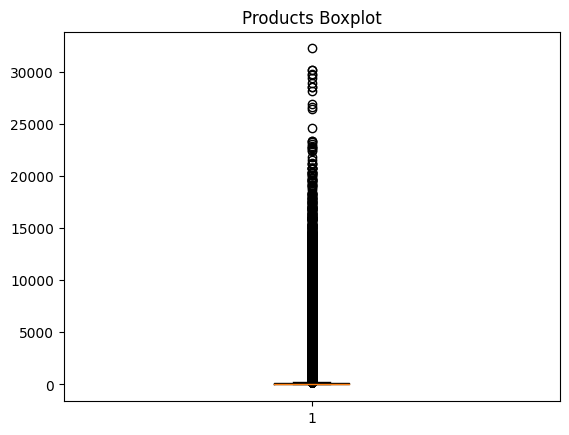

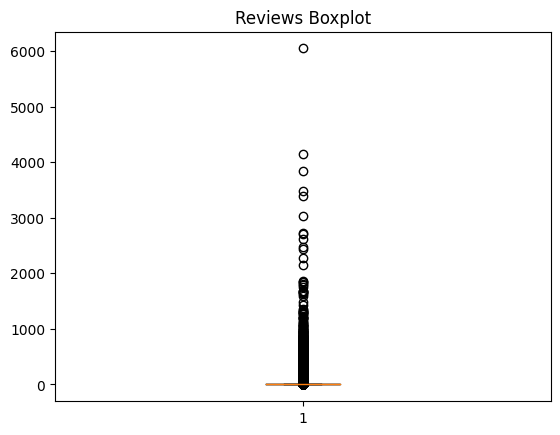

In [15]:
# 3.2.b Now users_df gets described and examined for outliers.
display(users_df.describe())

plt.boxplot(users_df["products"])
plt.title("Products Boxplot")
plt.show()

plt.boxplot(users_df["reviews"])
plt.title("Reviews Boxplot")
plt.show()

In [16]:
# 3.2.b users_df examination for outliers continued

# So we see that these are extremely skewed. The majority of users have 127 or fewer Steam products, and have made 3 or
# fewer reviews. Yet there are all these outliers with a huge amount of products or reviews!

# Thinking ahead, we might actually want to remove some of these outliers ... they are likely bots or mal-actor users who 
# intend to make tons of reviews for some potentially nefarious, selfish, or silly purpose. There are, for instance, review
# bots that rate games on whether or not they contain something in particular (e.g. a dog that can be pet). These are not
# useful to us, and removing them might make our dataset much more reflective of a more average user-- the true audience we 
# are trying to get at.

# Let's try another way of identifying the outliers: 3x STDev (if it falls beyond 3 standard deviations from the mean, it
# is an outlier).

ceil_reviews = users_df["reviews"].mean() + 3*users_df["reviews"].std() # ~26.8
# We don't bother with a lower bound; it would be a negative number in this case since the data is skewed so hard one direction.

reviews_outliers = users_df[(users_df["reviews"] > ceil_reviews)] # If reviews >= 27, then exclude

display(reviews_outliers.sort_values(by = "reviews"))

print(f"As anticipated, our outliers range 27 to 6045 reviews. The number of outliers actually represents <",end="")
print(f"{math.ceil(100*reviews_outliers.shape[0]/users_df.shape[0])}% of total reviews.")




,user_id,products,reviews
3105606,6448403,283,27
6746456,4568361,192,27
11190252,6985480,251,27
2082401,11182674,434,27
11188950,6700601,286,27
...,...,...,...
8734053,11553593,1919,3392
12041089,5669734,4737,3479
13741354,11656130,1807,3840
9965497,5112758,1226,4152


As anticipated, our outliers range 27 to 6045 reviews. The number of outliers actually represents <1% of total reviews.


In [17]:
users_df_clean = users_df.drop(reviews_outliers.index).sort_values(by = "reviews")
display(users_df_clean)

print("This represents the vast majority of reviewers, and hopefully cuts out many non-human reviewers.")
print("I don't think it makes too much sense to also curtail by number of products a reviewer has.")


,user_id,products,reviews
0,7360263,359,0
5139307,348011,62,0
5139317,351601,22,0
5139321,352897,16,0
5139379,366326,43,0
...,...,...,...
2536810,7113426,120,26
6794321,3264195,125,26
7190707,7900834,422,26
10404293,7161484,258,26


This represents the vast majority of reviewers, and hopefully cuts out many non-human reviewers.
I don't think it makes too much sense to also curtail by number of products a reviewer has.


In [18]:
# 3.2.c recom_df examination for outliers

recom_df.describe()   # Note: may take a long time.

,app_id,helpful,funny,hours,user_id,review_id
count,41154794,41154794,41154794,41154794,41154794,41154794
mean,603272,3,1,101,7450576,20577396
std,472923,47,29,176,4010685,11880366
min,10,0,0,0,0,0
25%,253940,0,0,8,4287256,10288698
50%,435150,0,0,27,7546446,20577396
75%,933110,0,0,99,10968771,30866095
max,2253290,36212,28109,1000,14306063,41154793


In [19]:
# 3.2.c continued
# Importantly, this information already is cut off: any user with >=1000 hours in a game is recorded as having ~1000 hours.

# Otherwise, the "helpful" and "funny" metrics don't seem to matter much. This is how much other users engage with a review.

# It might make sense to cut out the reviews with the least hours played, but even these are important: some games are extremely
# short, or some people may be simply unable to launch the game they've purchased.

# The other metrics are ID numbers, so no need to check for further outliers.

In [20]:
# 3.2.d
# And finally, the metadata (games_metadata.json)
gmeta_df.describe()

print("Since there isn't a numerical value outside app_id, we won't bother further examining games_metadata.")

Since there isn't a numerical value outside app_id, we won't bother further examining games_metadata.


### 3.3 Data Quality and Consistency

In [30]:
# 3.3.1 Ensured data quality by verifying data consistency and accuracy.

# We performed a check for missing values already. But if we're going to strike some entries in users_df, we should strike
# those users from the recom_df too.

display(reviews_outliers)
print("We will have to remove all entries with these user_id numbers from recom_df.\nThis amounts to",end=" ")
print(f"{reviews_outliers['reviews'].sum()} entries, so {recom_df.shape[0]-reviews_outliers['reviews'].sum()} will remain.")
display(recom_df)


,user_id,products,reviews
45,4616950,702,36
97,10057960,603,27
114,11316351,677,68
183,4363012,1001,72
199,4893896,496,50
...,...,...,...
14303304,3634355,60,32
14303394,3662507,57,28
14304388,3954523,137,46
14304876,4156581,367,80


We will have to remove all entries with these user_id numbers from recom_df.
This amounts to 6457737 entries, so 34697057 will remain.


,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36,51580,0
1,304390,4,0,2017-02-17,False,12,2586,1
2,1085660,2,0,2019-11-17,True,336,253880,2
3,703080,0,0,2022-09-23,True,27,259432,3
4,526870,0,0,2021-01-10,True,8,23869,4
...,...,...,...,...,...,...,...,...
41154789,633230,0,0,2021-02-15,True,41,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8,1786254,41154790
41154791,696170,3,10,2018-03-26,False,2,6370324,41154791
41154792,696170,0,0,2018-06-11,True,4,1044289,41154792


In [32]:
# 3.1.1 continued

# We remove all entries from recom_df that have a user_id contained in reviews_outliers:
recom_df_clean = recom_df[~recom_df["user_id"].isin(reviews_outliers["user_id"])]
display(recom_df_clean)

# Verify that these two numbers are the same: that means that we dropped exactly as many entries as we wanted to.
print(f"As expected, {recom_df.shape[0]-reviews_outliers['reviews'].sum()} = {recom_df_clean.shape[0]}") 

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36,51580,0
1,304390,4,0,2017-02-17,False,12,2586,1
2,1085660,2,0,2019-11-17,True,336,253880,2
3,703080,0,0,2022-09-23,True,27,259432,3
4,526870,0,0,2021-01-10,True,8,23869,4
...,...,...,...,...,...,...,...,...
41154788,391220,0,0,2021-04-28,True,18,9958247,41154788
41154789,633230,0,0,2021-02-15,True,41,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8,1786254,41154790
41154792,696170,0,0,2018-06-11,True,4,1044289,41154792


As expected, 34697057 = 34697057


In [36]:
# 3.3.2 Check for duplicate records or potential errors; correct them as needed.

# Duplicates are simple:
print(f"games_df contains {games_df.duplicated().sum()} duplicates.")
print(f"users_df_clean contains {users_df_clean.duplicated().sum()} duplicates.")
print(f"recom_df_clean contains {recom_df_clean.duplicated().sum()} duplicates.")  # Warning, takes a long time.

0
0
0


In [37]:
# 3.3.3 If a transformation was made, what was it and why?

# We made sure that all the outlier reviewers that had made too many reviews in users_df were also struck from recom_df; this
# means that our products (users_df_clean and recom_df_clean) will not have orphaned user_id numbers that exist in one and not  
# the other.

### 3.4 Data Preparation for Model Training

In [ ]:
# It has become obvious at this point that the most important dataset we're working with is the recommendations.csv, and our
# version of it: recom_df_clean. 